In [5]:
import sys
sys.path.append('../')
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
hyperparams = {
    # 'learning_rate': 5e-4,  # Control dropout rate
    'learning_rate': 5e-4,  # Control dropout rate
    'patience': 4,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}

num_epochs = 100
print_every = 1

hidden_sizes1 = 128
hidden_sizes2 = 1024
hidden_sizes3 = 128
num_hidden = 5
hidden_sizes1 = 128
hidden_sizes2 = 1024
hidden_sizes3 = 128
num_hidden = 10

In [7]:
knot_types = {
        'standard_16': 0,  # 1
        'standard_14': 1,  # 2
        'standard_18': 2,  # 3
        '30both': 3,  # 4
        '30oneZ': 4,  # 5
        'optimized': 5,  # 6
        'pm_03_z': 6,  # 7
        # '4foil': hopf_4foil,  # 8
        # '6foil': hopf_6foil,  # 9
        # 'stand4foil': hopf_stand4foil,  # 10
        '30oneX': 7,  # 11
        '15oneZ': 8,
        'dennis': 9,
        'trefoil_standard_12': 10,
        'trefoil_optimized': 11,
        # 'fivefoil_standard_08': fivefoil_standard_08

}


knots = [
    'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
    'optimized', 'pm_03_z', '30oneX', '15oneZ', 'dennis',
    'trefoil_standard_12', 'trefoil_optimized'
]


folders = [
    '../HOPFS_L270_0.05_1000_64x64x64_v1',
    '../HOPFS_L270_0.15_1000_64x64x64_v1',
    '../HOPFS_L270_0.25_1000_64x64x64_v1',
]


num_classes = len(knots)
X_list = []
Y_list = []
Xs_list = []
Ys_list = []

csv.field_size_limit(10000000)

# Loop through all folders and knots
for folder in folders:
    for knot in knots:
        filename = f'{folder}/data_{knot}_spectr.csv'
        try:
            with open(filename, 'r') as file:
                reader = csv.reader(file)
                for row in reader:
                    # Append the knot label to Ys_list
                    Ys_list.append(knot_types[knot])

                    # Load the data array from the JSON string
                    data_array = json.loads(row[0])

                    # Extract values from the data array
                    l1, l2 = data_array[0], data_array[1]
                    p1, p2 = data_array[2], data_array[3]

                    # Create and normalize the moments array
                    moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]])
                    moments = moments.reshape((l2 - l1 + 1), (p2 - p1 + 1))
                    moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))

                    # Append the flattened absolute values to Xs_list
                    Xs_list.append(np.abs(moments.reshape(-1)))

        except FileNotFoundError:
            print(f'File not found: {filename}')
        except json.JSONDecodeError:
            print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')

Loaded 0 samples.  0 per class


In [8]:
Xs_np = np.array(Xs_list)
ys_np = np.array(Ys_list)
# print(ys_np.shape)
Xs_torch = torch.tensor(Xs_np).float()
ys_t = torch.tensor(ys_np)
ys_torch = F.one_hot(ys_t.long(), num_classes=num_classes).float()
print(Xs_torch.shape, ys_torch.shape)

torch.Size([132, 91]) torch.Size([132, 12])


In [9]:
X_train, X_val_test, y_train, y_val_test = train_test_split(Xs_torch, ys_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [10]:


class ClassifierConvSpec(nn.Module):
    def __init__(self, shape_X_l, shape_X_p, num_classes):
        super(ClassifierConvSpec, self).__init__()

        # First convolutional layer with batch normalization
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        # Third convolutional layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # Adaptive pooling to reduce dimensionality if needed
        self.pool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected output layer
        self.fc = nn.Linear(64 * 4 * 4, num_classes)

    def forward(self, x):
        # Reshape the input to (batch_size, 1, shape_X_l, shape_X_p)
        x = x.view(x.size(0), 1, shape_X_l, shape_X_p)

        # Apply the convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Pool the result to reduce dimensionality
        x = self.pool(x)

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        # Output layer
        x = self.fc(x)
        return x

In [11]:
# Example usage
shape_X_l = 7  # Modify as needed
shape_X_p = 13  # Modify as needed
num_classes = ys_torch.shape[-1]

# Initialize the model
model = ClassifierConvSpec(shape_X_l, shape_X_p, num_classes).to(device)

# Print model summary (Optional)
print(model)

ClassifierConvSpec(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc): Linear(in_features=1024, out_features=12, bias=True)
)


In [12]:
# print(model._to_linear, 512 * 16 * 16)
dots_3d_toch_batch = train_dataset[1:4][0].to(device)
print(dots_3d_toch_batch.shape)
print(model(dots_3d_toch_batch).shape)
summary(model, input_size=dots_3d_toch_batch.shape[1:])

torch.Size([3, 91])
torch.Size([3, 12])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 16, 7, 13]             160
       BatchNorm2d-2            [-1, 16, 7, 13]              32
              ReLU-3            [-1, 16, 7, 13]               0
            Conv2d-4            [-1, 32, 7, 13]           4,640
       BatchNorm2d-5            [-1, 32, 7, 13]              64
              ReLU-6            [-1, 32, 7, 13]               0
            Conv2d-7            [-1, 64, 7, 13]          18,496
       BatchNorm2d-8            [-1, 64, 7, 13]             128
              ReLU-9            [-1, 64, 7, 13]               0
AdaptiveAvgPool2d-10             [-1, 64, 4, 4]               0
           Linear-11                   [-1, 12]          12,300
Total params: 35,820
Trainable params: 35,820
Non-trainable params: 0
---------------------------------------------------------

In [13]:
train_dataset[1:2][0]

tensor([[4.6387e-05, 2.2017e-05, 4.1045e-05, 4.3364e-05, 2.6819e-05, 3.5398e-05,
         2.6810e-05, 4.1336e-05, 3.5944e-05, 1.1803e-06, 1.3765e-05, 6.1735e-06,
         1.2568e-05, 1.6452e-05, 8.3469e-05, 2.6047e-05, 1.8260e-04, 4.5117e-04,
         6.4492e-04, 4.3694e-04, 2.0579e-04, 9.1498e-05, 5.6196e-05, 3.7990e-05,
         2.1209e-05, 1.0520e-05, 1.6337e-05, 1.2209e-05, 1.2364e-04, 1.1329e-04,
         1.0256e-04, 2.9390e-05, 5.8968e-05, 9.2591e-05, 5.9887e-05, 3.1635e-04,
         4.6738e-04, 3.3220e-04, 8.1445e-05, 2.7949e-05, 3.5306e-05, 2.0466e-05,
         2.6292e-01, 6.3216e-01, 4.2105e-01, 1.3459e-04, 2.7177e-04, 7.0652e-04,
         9.1455e-04, 3.5986e-04, 6.0580e-04, 2.9552e-04, 9.4468e-05, 3.5680e-05,
         3.4238e-05, 1.9145e-05, 5.9494e-01, 1.6821e-04, 5.5187e-05, 6.0124e-05,
         6.0842e-05, 1.0935e-04, 7.2665e-05, 3.9111e-04, 7.7478e-05, 1.1014e-04,
         4.2463e-05, 1.5377e-05, 6.1185e-06, 8.5051e-06, 1.0105e-04, 5.5363e-05,
         1.6382e-04, 4.4759e

In [14]:
def loop_train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):  # Start enumeration from 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)  # Return the average loss


def loop_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(test_loader)  # Return the average loss


def correct_number_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            correct = criterion(outputs, targets)  # Compute correct
            total_correct += correct  # Accumulate correct
            total += len(outputs)  # Accumulate total
    return total_correct, total  # Return the average loss


def plot_losses(train_losses, test_losses, decimals=3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses,
             label=f'Train Loss {train_losses[-1]: .{decimals}f} (min: {min(train_losses): .{decimals}f})')
    plt.plot(test_losses, label=f'Test Loss {test_losses[-1]: .{decimals}f} (min: {min(test_losses): .{decimals}f})')
    plt.title('Training and Testing Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [15]:

# criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'],
                              verbose=True)



train_losses = []
val_losses = []
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])
start_time = time.time()
for epoch in trange(num_epochs, desc="Progress"):
    epoch_start_time = time.time()
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(loop_test(model, val_loader, criterion))

    scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch} completed in {epoch_time:.2f} seconds')
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


total_training_time = time.time() - start_time
print(f'Total training time: {total_training_time:.2f} seconds')

Progress:  14%|█▍        | 14/100 [00:00<00:01, 61.27it/s]

Epoch 0 completed in 0.17 seconds
Epoch 0: Train Loss: 2.5061, Val Loss: 2.4920
Epoch 1 completed in 0.01 seconds
Epoch 1: Train Loss: 2.3503, Val Loss: 2.4982
Epoch 2 completed in 0.01 seconds
Epoch 2: Train Loss: 2.2656, Val Loss: 2.5025
Epoch 3 completed in 0.01 seconds
Epoch 3: Train Loss: 2.2482, Val Loss: 2.5051
Epoch 4 completed in 0.01 seconds
Epoch 4: Train Loss: 2.1903, Val Loss: 2.5084
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5 completed in 0.01 seconds
Epoch 5: Train Loss: 2.1277, Val Loss: 2.5067
Epoch 6 completed in 0.01 seconds
Epoch 6: Train Loss: 2.0813, Val Loss: 2.5058
Epoch 7 completed in 0.01 seconds
Epoch 7: Train Loss: 2.0674, Val Loss: 2.5028
Epoch 8 completed in 0.01 seconds
Epoch 8: Train Loss: 2.0753, Val Loss: 2.4981
Epoch 9 completed in 0.01 seconds
Epoch 9: Train Loss: 2.0332, Val Loss: 2.4907
Epoch 10 completed in 0.01 seconds
Epoch 10: Train Loss: 2.0578, Val Loss: 2.4816
Epoch 11 completed in 0.01 seconds
Epoch 11: Train Loss:

Progress:  39%|███▉      | 39/100 [00:00<00:00, 99.09it/s]

Epoch 25 completed in 0.01 seconds
Epoch 25: Train Loss: 1.8018, Val Loss: 2.0498
Epoch 26 completed in 0.01 seconds
Epoch 26: Train Loss: 1.8173, Val Loss: 2.0170
Epoch 27 completed in 0.01 seconds
Epoch 27: Train Loss: 1.8067, Val Loss: 1.9851
Epoch 28 completed in 0.01 seconds
Epoch 28: Train Loss: 1.8171, Val Loss: 1.9555
Epoch 29 completed in 0.01 seconds
Epoch 29: Train Loss: 1.8108, Val Loss: 1.9265
Epoch 30 completed in 0.01 seconds
Epoch 30: Train Loss: 1.7728, Val Loss: 1.8972
Epoch 31 completed in 0.01 seconds
Epoch 31: Train Loss: 1.8007, Val Loss: 1.8657
Epoch 32 completed in 0.01 seconds
Epoch 32: Train Loss: 1.7351, Val Loss: 1.8391
Epoch 33 completed in 0.01 seconds
Epoch 33: Train Loss: 1.6893, Val Loss: 1.8149
Epoch 34 completed in 0.01 seconds
Epoch 34: Train Loss: 1.7253, Val Loss: 1.7937
Epoch 35 completed in 0.01 seconds
Epoch 35: Train Loss: 1.7134, Val Loss: 1.7740
Epoch 36 completed in 0.01 seconds
Epoch 36: Train Loss: 1.6859, Val Loss: 1.7567
Epoch 37 complet

Progress:  65%|██████▌   | 65/100 [00:00<00:00, 114.48it/s]

Epoch 51 completed in 0.01 seconds
Epoch 51: Train Loss: 1.5066, Val Loss: 1.5495
Epoch 52 completed in 0.01 seconds
Epoch 52: Train Loss: 1.5159, Val Loss: 1.5309
Epoch 53 completed in 0.01 seconds
Epoch 53: Train Loss: 1.4999, Val Loss: 1.5128
Epoch 54 completed in 0.01 seconds
Epoch 54: Train Loss: 1.4553, Val Loss: 1.4954
Epoch 55 completed in 0.01 seconds
Epoch 55: Train Loss: 1.4360, Val Loss: 1.4800
Epoch 56 completed in 0.01 seconds
Epoch 56: Train Loss: 1.4470, Val Loss: 1.4642
Epoch 57 completed in 0.01 seconds
Epoch 57: Train Loss: 1.4482, Val Loss: 1.4521
Epoch 58 completed in 0.01 seconds
Epoch 58: Train Loss: 1.3933, Val Loss: 1.4424
Epoch 59 completed in 0.01 seconds
Epoch 59: Train Loss: 1.3966, Val Loss: 1.4318
Epoch 60 completed in 0.01 seconds
Epoch 60: Train Loss: 1.3879, Val Loss: 1.4221
Epoch 61 completed in 0.01 seconds
Epoch 61: Train Loss: 1.4012, Val Loss: 1.4132
Epoch 62 completed in 0.01 seconds
Epoch 62: Train Loss: 1.3753, Val Loss: 1.4060
Epoch 63 complet

Progress:  91%|█████████ | 91/100 [00:00<00:00, 115.74it/s]

Epoch 78 completed in 0.01 seconds
Epoch 78: Train Loss: 1.2061, Val Loss: 1.2089
Epoch 79 completed in 0.01 seconds
Epoch 79: Train Loss: 1.1878, Val Loss: 1.1981
Epoch 80 completed in 0.01 seconds
Epoch 80: Train Loss: 1.1988, Val Loss: 1.1873
Epoch 81 completed in 0.01 seconds
Epoch 81: Train Loss: 1.1749, Val Loss: 1.1747
Epoch 82 completed in 0.01 seconds
Epoch 82: Train Loss: 1.1756, Val Loss: 1.1587
Epoch 83 completed in 0.01 seconds
Epoch 83: Train Loss: 1.1285, Val Loss: 1.1451
Epoch 84 completed in 0.01 seconds
Epoch 84: Train Loss: 1.1260, Val Loss: 1.1349
Epoch 85 completed in 0.01 seconds
Epoch 85: Train Loss: 1.1177, Val Loss: 1.1268
Epoch 86 completed in 0.01 seconds
Epoch 86: Train Loss: 1.0873, Val Loss: 1.1216
Epoch 87 completed in 0.01 seconds
Epoch 87: Train Loss: 1.0853, Val Loss: 1.1208
Epoch 88 completed in 0.01 seconds
Epoch 88: Train Loss: 1.0895, Val Loss: 1.1173
Epoch 89 completed in 0.01 seconds
Epoch 89: Train Loss: 1.0737, Val Loss: 1.1115
Epoch 90 complet

Progress: 100%|██████████| 100/100 [00:00<00:00, 102.05it/s]

Total training time: 0.98 seconds


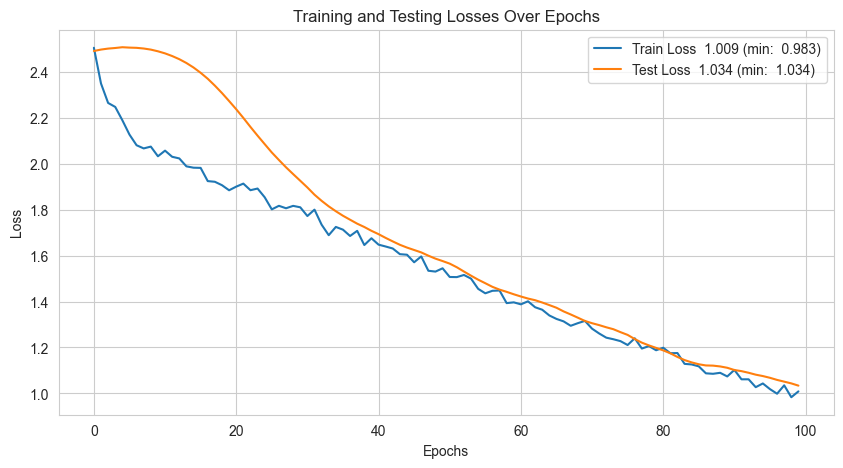

In [16]:
plot_losses(train_losses, val_losses, decimals=3)

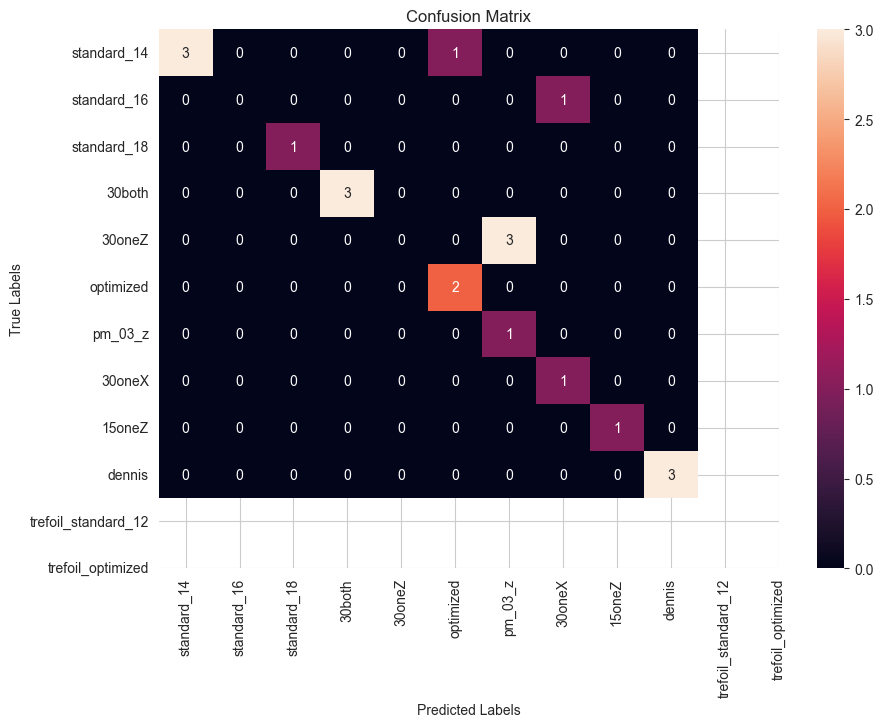

In [17]:
# predictions = model(X_torch.to(device))
# predictions
model.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_test, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

0.75


In [19]:
def criterion_correct(predictions, labels):
    _, predicted_labels = torch.max(predictions, 1)
    _, true_class_labels = torch.max(labels, 1)
    # print(predicted_labels)
    # print(y_torch)
    correct_predictions = torch.sum(predicted_labels == true_class_labels).item()
    return correct_predictions


correct_predictions, total = correct_number_test(model, test_loader, criterion_correct)
print(f"Number of correct predictions (test): {correct_predictions}/{total}")

correct_predictions, total = correct_number_test(model, val_loader, criterion_correct)
print(f"Number of correct predictions (val): {correct_predictions}/{total}")

Number of correct predictions (test): 15/20
Number of correct predictions (val): 13/20


Creating the least of the weights in 2D as a basis

In [20]:
def build_weights(weights, ls, ps, l1, l2, p1, p2):
    weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
    for l, p, weight in zip(ls, ps, weights):
        weights_ar[l - l1, p - p1] = weight
    return weights_ar

# getting the dimensions
filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
with open(filename, 'r') as file:
    reader = csv.reader(file)
    row = next(iter(reader))
    data_list = json.loads(row[0])
    # Convert the list back to a NumPy array if needed
    # print(data_list)
    # data_array = np.array(data_list)
    data_array = data_list

    l1, l2 = data_array[0], data_array[1]
    p1, p2 = data_array[2], data_array[3]
print(l1, l2, p1, p2)

values_basis = []
for knot in knots:
# for knot in ['6foil']:
    print(knot)
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:

        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        values = build_weights(weights, ls, ps, l1, l2, p1, p2)
        values = values / np.sqrt(np.sum(np.abs(values) ** 2))
        values_basis.append(values)
        # plt.imshow(np.abs(values).T[::-1])
        # plt.colorbar()
        # plt.show()

print(len(values_basis), values_basis[0].shape)

FileNotFoundError: [Errno 2] No such file or directory: '..\\../HOPFS_L270_0.05_1_64x64x64_v1\\data_standard_14_spectr.csv'

In [ ]:
# Function to calculate MSE
def calculate_mse(array1, array2):
    return ((np.abs(array1) - np.abs(array2)) ** 2).mean()

closest_basis_knots = []
true_labels = []
for knot in knots:
    closest_basis_knot = []
    true_label = []
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            true_label.append(knot_types[knot])
            data_array = json.loads(row[0])

            # indx = data_array[4]
            # field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            # plt.imshow(np.abs(field ))
            # plt.show()

            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))
            mse_scores = [calculate_mse(moments, values) for values in values_basis]
            closest_basis_knot.append(np.argmin(mse_scores))
            # plt.imshow(np.abs(moments))
            # plt.colorbar()
            # plt.show()
    true_labels.append(true_label)
    closest_basis_knots.append(closest_basis_knot)

# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:
predicted_labels_spec_np = np.array(closest_basis_knots).reshape(-1)
true_labels_spec_np = np.array(true_labels).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# def build_weights(weights, ls, ps, l1, l2, p1, p2):
#     weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
#     for l, p, weight in zip(ls, ps, weights):
#         weights_ar[l - l1, p - p1] = weight
#     return weights_ar
#
# # getting the dimensions
# filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
# with open(filename, 'r') as file:
#     reader = csv.reader(file)
#     row = next(iter(reader))
#     data_list = json.loads(row[0])
#     # Convert the list back to a NumPy array if needed
#     # print(data_list)
#     # data_array = np.array(data_list)
#     data_array = data_list
#
#     l1, l2 = data_array[0], data_array[1]
#     p1, p2 = data_array[2], data_array[3]
# print(l1, l2, p1, p2)

knots_basis = []
knots_basis_dots = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\data_basis\\data_{knot}.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            data_array = np.array(data_list)
            points_list = data_array[2:]

            Nx, Ny, Nz = data_array[1]
            if desired_res != (Nx, Ny, Nz):
                scale_x = desired_res[0] / Nx
                scale_y = desired_res[1] / Ny
                scale_z = desired_res[2] / Nz
                points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            knots_basis_dots.append(points_list)
            # Initialize a 3D array with zeros
            dots_3d = np.zeros(desired_res, dtype=int)
            # Set the specified coordinates to 1
            for x, y, z in points_list:
                try: dots_3d[x, y, z] = 1
                except IndexError: continue
            knots_basis.append(dots_3d)

print(len(knots_basis), knots_basis[0].shape)
print(len(knots_basis_dots), knots_basis_dots[0].shape,knots_basis_dots[0][0])
print(knots_basis_dots[0].shape, knots_basis_dots[3].shape)

In [ ]:
# Function to calculate MSE
def calculate_mse_knot(array1, array2):
    return ((array1 - array2) ** 2).mean()

def calculate_mse_knot_dots(array1, dots):
    # loss = -np.sum([np.array(array1)[np.array(dot)] for dot in dots])
    loss = -np.sum([array1[tuple(dot)] for dot in dots])

    return loss

closest_knots = []
closest_knots_dots = []
true_knots = []
j = -1
for i, x in enumerate(X_torch):
    j += 1
    true_knots.append(torch.argmax(y_torch[i]).item())

    mse_scores = [calculate_mse_knot(x[0], knot_) for knot_ in knots_basis]
    closest_knots.append(np.argmin(mse_scores))

    mse_scores_dots = [calculate_mse_knot_dots(x[0], dots_) for dots_ in knots_basis_dots]
    # print(mse_scores_dots)
    # min_indices = np.where(mse_scores_dots == np.min(mse_scores_dots))[0]
    # if len(min_indices) > 1:
    #     result = 0
    # else:
    #     result = min_indices[0]
    closest_knots_dots.append(np.argmin(mse_scores_dots))
    # plt.imshow(knots_basis[j][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(x[0][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # break


# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:

predicted_labels_spec_np = np.array(closest_knots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

predicted_labels_spec_np = np.array(closest_knots_dots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:


X_list_sp = []
Y_list_sp = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:
        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        for row in reader:
                # Deserialize the JSON string back to a list
                data_list = json.loads(row[0])
                # Convert the list back to a NumPy array if needed
                # print(data_list)
                # data_array = np.array(data_list)
                data_array = data_list

                l1, l2 = data_array[0], data_array[1]
                p1, p2 = data_array[2], data_array[3]

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            # print(data_list)
            # data_array = np.array(data_list)
            data_array = data_list

            l1, l2 = data_array[0], data_array[1]
            p1, p2 = data_array[2], data_array[3]
            indx = data_array[4]
            field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            plt.imshow(np.abs(field ))
            plt.show()

            # print(f'l1, l2, p1, p2: {l1}, {l2}, {p1}, {p2} ({(l2 - l1 + 1) * (p2 - p1 + 1)})')
            # moments = np.array(data_array[4:]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            # plt.imshow(np.abs(moments).T[::-1, :])
            # plt.show()
            values = build_weights(weights, ls, ps, l1, l2, p1, p2)
            print(f"{knot}")
            plt.imshow(np.abs(values))
            plt.colorbar()
            plt.show()
            plt.imshow(np.abs(moments))
            plt.colorbar()
            plt.show()
            # plt.imshow(np.real(moments).T[::-1, :])
            # plt.show()
            print(moments)
            break
            # continue
            # points_list = data_array[2:]
            # Nx, Ny, Nz = data_array[1]
            # if desired_res != (Nx, Ny, Nz):
            #     scale_x = desired_res[0] / Nx
            #     scale_y = desired_res[1] / Ny
            #     scale_z = desired_res[2] / Nz
            #     points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            # # Initialize a 3D array with zeros
            # dots_3d = np.zeros(desired_res, dtype=int)
            # # Set the specified coordinates to 1
            # for x, y, z in points_list:
            #     try: dots_3d[x, y, z] = 1
            #     except IndexError: continue
            # X_list.append(dots_3d)
            # # X_list.append(data_array)
            # Y_list.append(knot_types[knot])
    break

In [ ]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
# X_torch = torch.tensor(X_np).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)